In [20]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib

# Load Data

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

dataarray_SST_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_piControl_interp_2x2_15memens_2.nc')
dataarray_SST_cont.load()

dataarray_TOA_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2_15memens.nc')
dataarray_TOA_cont.load()

dataarray_SST_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_historical_interp_2x2_15memens.nc')
dataarray_SST_hist.load()

dataarray_TOA_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_15memens.nc')
dataarray_TOA_hist.load()

dataarray_Qs_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_15memens.nc')
dataarray_Qs_hist.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 4.90165056e+00,  5.02030481e+00,  5.14833517e+00, ...,
           4.42925605e+00,  4.56485558e+00,  4.66646627e+00],
         [ 4.59733384e+00,  4.82168076e+00,  4.98723783e+00, ...,
           3.81284670e+00,  3.96564983e+00,  4.19904078e+00],
         [ 4.02822119e+00,  4.18452456e+00,  4.37871187e+00, ...,
           3.16195200e+00,  3.32776068e+00,  3.54453707e+00],
         ...,
         [-3.46124473e+01, -3.68575683e+01, -3.48434307e+01, ...,
          -3.44554857e+01, -3.57958553e+01, -3.51358641e+01],
         [-3.32735436e+01, -3.38893754e+01, -3.38385741e+01, ...,
          -3.26756667e+01, -3.27437460e+01, -3.27906597e+01],
         [-3.46177860e+01, -3.51192427e+01, -3.58445793e+01, ...,
          -3.36690564e+01, -3.51623532e+01, -3.55597275e+01]],

        [[-2.86197465e+00, -2.93874279e+00, -3.03927916e+00, ...,
          -2.56575976e+00, -2.67832265e+00, -2.74031600e+00],
         [-2.12785747e+00, -2.32005957e+00, -2.40554916e+00, ...,
          -1.76238901e+00, -1.80849465e+00, -1.92474648e+00],
         [-1.41721594e+00, -1.48068312e+00, -1.55627523e+00, ...,
          -9.75113796e-01, -1.02866159e+00, -1.15787975e+00],
...
         [-2.78088935e+01, -2.78776526e+01, -2.93542580e+01, ...,
          -1.90225108e+01, -1.93425562e+01, -2.20628261e+01],
         [-2.44885393e+01, -2.53342339e+01, -2.67468318e+01, ...,
          -1.73685251e+01, -2.00562108e+01, -2.04017211e+01],
         [-2.17705019e+01, -2.34594400e+01, -2.61322040e+01, ...,
          -2.20741132e+01, -2.23441102e+01, -2.22555440e+01]],

        [[ 2.00020313e+01,  2.02547712e+01,  2.04408099e+01, ...,
           1.97594779e+01,  1.98033927e+01,  1.99940870e+01],
         [ 1.87190357e+01,  1.87650739e+01,  1.88504934e+01, ...,
           1.84766899e+01,  1.86177975e+01,  1.85550708e+01],
         [ 1.79714223e+01,  1.81370286e+01,  1.83174774e+01, ...,
           1.72408851e+01,  1.75626934e+01,  1.76884266e+01],
         ...,
         [-3.28068227e+01, -3.18609009e+01, -3.11594645e+01, ...,
          -2.05865988e+01, -2.25901160e+01, -2.73886632e+01],
         [-2.14137497e+01, -2.32414394e+01, -2.30369152e+01, ...,
          -1.75088925e+01, -1.97793967e+01, -2.07191078e+01],
         [-2.20522095e+01, -2.36049736e+01, -2.36618611e+01, ...,
          -2.03961387e+01, -2.12793080e+01, -2.13185888e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3'

In [3]:
def yearly_fit(sst_dataset, rad_dataset):
    """
    Yearly regression
    
    """
    rad_dataset_yearly = rad_dataset.rolling(time=12, center=True).mean('time')
    rad_dataset_yearly = rad_dataset_yearly.isel(time=slice(12,1488))
    sst_dataset_yearly = sst_dataset.rolling(time=12, center=True).mean('time')
    sst_dataset_yearly = sst_dataset_yearly.isel(time=slice(12,1488))
    
    SST_radfit = xr.DataArray(np.zeros((15,88,179)), dims=['name','lat','lon'])
    model_index = 0
    for model in rad_dataset_yearly.coords['name'].values:
        lat_index = 0
        for lat in rad_dataset_yearly.coords['lat'].values:
            lon_index = 0
            for lon in rad_dataset_yearly.coords['lon'].values:
                SST_slice = sst_dataset_yearly.sel(lat=lat).sel(lon=lon).sel(name=model)
                rad_slice = rad_dataset_yearly.sel(lat=lat).sel(lon=lon).sel(name=model)
                idx = np.isfinite(SST_slice) & np.isfinite(rad_slice)
                if not SST_slice[idx].size or not rad_slice[idx].size:
                    break
                SST_radfit[model_index, lat_index, lon_index] = np.polyfit(SST_slice[idx], rad_slice[idx], deg=1)[0]     
                lon_index += 1
            lat_index += 1
        model_index += 1
        print(model)

    SST_radfit.coords['lon'] = rad_dataset_yearly['lon'].values
    SST_radfit.coords['lat'] = rad_dataset_yearly['lat'].values
    SST_radfit.coords['name'] = rad_dataset_yearly['name'].values
    SST_radfit
    return SST_radfit

# Historical SST and TOA

In [4]:
sst_toa_fit = yearly_fit(dataarray_SST_hist, dataarray_TOA_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3


In [5]:
sst_toa_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-1.15953878e-01, -1.21710592e-01, -1.27811861e-01, ...,
         -9.83661987e-02, -1.05744497e-01, -1.08713017e-01],
        [-1.37021886e-01, -1.46019985e-01, -1.52905418e-01, ...,
         -1.14054615e-01, -1.21717322e-01, -1.25648531e-01],
        [-1.08118020e-01, -1.12725473e-01, -1.24306574e-01, ...,
         -8.61254034e-02, -8.93152293e-02, -9.33642318e-02],
        ...,
        [-2.13296259e-01, -2.27149335e-01, -2.34896273e-01, ...,
         -1.66545233e-01, -1.83872911e-01, -2.01170868e-01],
        [-2.09155189e-01, -2.12706447e-01, -2.16544557e-01, ...,
         -2.36855541e-01, -2.32522366e-01, -2.22569561e-01],
        [-2.34100123e-01, -2.32283961e-01, -2.34110006e-01, ...,
         -2.34178747e-01, -2.38173222e-01, -2.37740397e-01]],

       [[-1.44136719e-01, -1.49619015e-01, -1.48816659e-01, ...,
         -1.37032164e-01, -1.37974030e-01, -1.39774010e-01],
        [-1.37690190e-01, -1.43645209e-01, -1.47054191e-01, ...,
         -1.18658246e-01, -1.22397533e-01, -1.26831529e-01],
        [-1.81407214e-01, -1.86214347e-01, -1.88760420e-01, ...,
         -1.44118878e-01, -1.54780798e-01, -1.66032403e-01],
...
        [-7.11727609e-01, -6.72198168e-01, -6.27714647e-01, ...,
         -8.26080780e-01, -7.99655030e-01, -7.66627404e-01],
        [-9.22409043e-01, -9.10520459e-01, -8.97533907e-01, ...,
         -9.87653360e-01, -9.68362446e-01, -9.50620272e-01],
        [-9.03801171e-01, -8.91861198e-01, -8.82981228e-01, ...,
         -9.45541927e-01, -9.35779658e-01, -9.27642795e-01]],

       [[ 7.28786779e-03,  6.99902719e-03,  1.87198050e-02, ...,
         -1.95304170e-02, -4.14083694e-03,  1.08299353e-02],
        [-7.81041765e-02, -6.91049210e-02, -5.53323930e-02, ...,
         -8.46387549e-02, -7.30219153e-02, -7.21757403e-02],
        [-1.57130254e-01, -1.52285008e-01, -1.49787593e-01, ...,
         -1.36795419e-01, -1.41262727e-01, -1.40617466e-01],
        ...,
        [ 2.09523550e-01,  2.06679827e-01,  2.02525575e-01, ...,
          1.90723836e-01,  2.01100525e-01,  2.12541508e-01],
        [ 1.55241740e-01,  1.47882745e-01,  1.46014738e-01, ...,
          1.35245296e-01,  1.40553715e-01,  1.39440593e-01],
        [-8.50283752e-03, -5.07752744e-03, -6.09885651e-03, ...,
          6.32016143e-03,  9.35774295e-03, -5.80980274e-04]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3'

In [6]:
sst_toa_fit.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/yearly_regression_sst_toa_hist_15model.nc')

In [6]:
sst_toa_fit_mean = sst_toa_fit.mean('name')

Text(0.5, 1.0, 'Yearly Regression of Historical SST and TOA Radiation (N=15)')

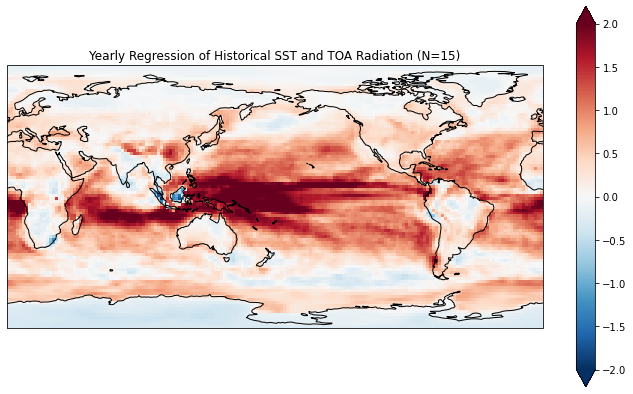

In [10]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Regression of Historical SST and TOA Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Regression of Historical SST and TOA Radiation (N=15)')

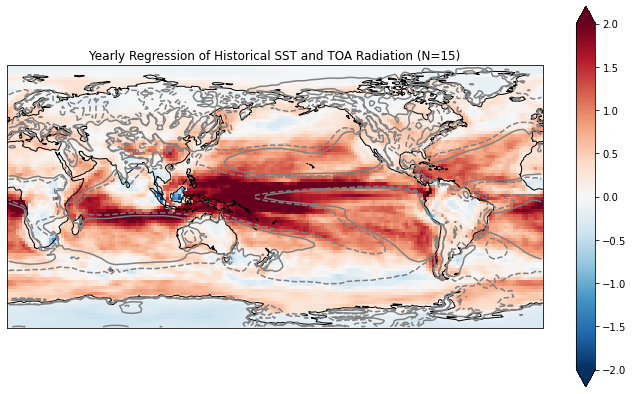

In [11]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Regression of Historical SST and TOA Radiation (N=15)')

# piControl SST + TOA

In [5]:
sst_toa_cont_fit = yearly_fit(dataarray_SST_cont, dataarray_TOA_cont)

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-H


In [6]:
sst_toa_cont_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-0.95677105, -0.9681558 , -0.97809246, ..., -0.91911945,
         -0.92851681, -0.93732907],
        [-0.92826213, -0.9443599 , -0.9641848 , ..., -0.85864801,
         -0.87619263, -0.89371425],
        [-0.91817971, -0.94488408, -0.96984744, ..., -0.8136457 ,
         -0.83884791, -0.86559548],
        ...,
        [-1.15443135, -1.15949332, -1.15728654, ..., -1.09396227,
         -1.11932705, -1.13576103],
        [-1.23109174, -1.23352467, -1.23731624, ..., -1.23368929,
         -1.2287362 , -1.2246989 ],
        [-1.20566955, -1.1982175 , -1.19971598, ..., -1.21142732,
         -1.21614965, -1.21679272]],

       [[-1.04268593, -1.04972494, -1.05864297, ..., -1.01120761,
         -1.01671617, -1.02540692],
        [-1.05854234, -1.07381795, -1.08990553, ..., -1.00469808,
         -1.01684228, -1.03018068],
        [-1.09188934, -1.11386381, -1.13695398, ..., -1.01533817,
         -1.03262405, -1.05155177],
...
        [-1.0150991 , -0.98729725, -0.94369808, ..., -1.27264705,
         -1.26342037, -1.2448158 ],
        [-1.1686283 , -1.12190437, -1.09088994, ..., -1.24051124,
         -1.22850605, -1.21609953],
        [-1.18346138, -1.17529147, -1.16664533, ..., -1.2153768 ,
         -1.2075525 , -1.19961128]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'GISS-E2-1-H'

In [7]:
sst_toa_cont_fit_mean = sst_toa_cont_fit.mean('name')

Text(0.5, 1.0, 'Yearly Regression of piControl SST and TOA Radiation (N=15)')

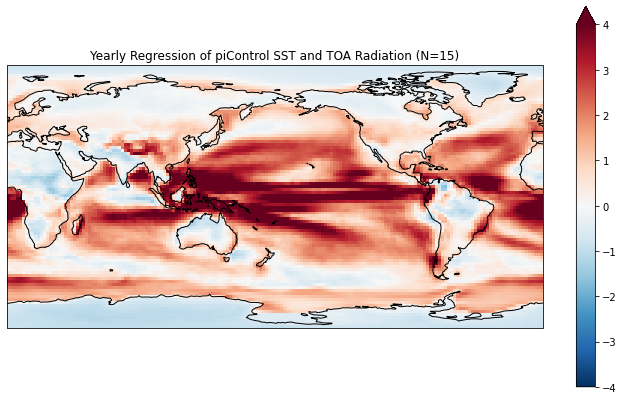

In [15]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Regression of piControl SST and TOA Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Regression of piControl SST and TOA Radiation (N=15)')

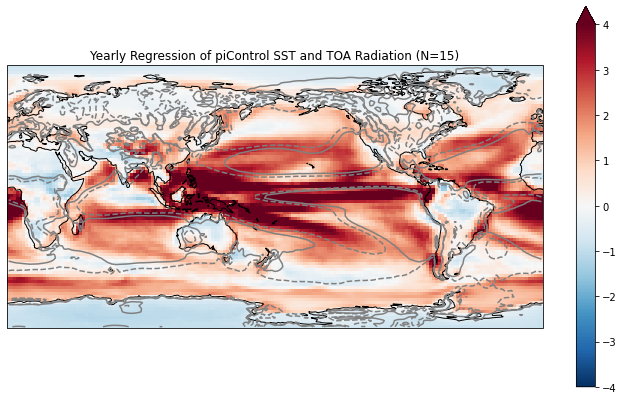

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Regression of piControl SST and TOA Radiation (N=15)')

# Historical Surface + SST

In [4]:
sst_surf_fit = yearly_fit(dataarray_SST_hist, dataarray_Qs_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3


In [5]:
sst_surf_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-1.53588324e-02, -1.56767967e-02, -1.63707873e-02, ...,
         -1.35503412e-02, -1.46095938e-02, -1.46063950e-02],
        [-1.78512272e-02, -1.85988941e-02, -1.89526828e-02, ...,
         -1.72253525e-02, -1.68379516e-02, -1.77038168e-02],
        [-1.46379703e-02, -1.52505951e-02, -1.55309055e-02, ...,
         -1.30745981e-02, -1.36698342e-02, -1.40595062e-02],
        ...,
        [ 1.51384120e-01,  1.20541064e-01,  9.88059263e-02, ...,
          1.15212968e-01,  1.47083196e-01,  1.56893141e-01],
        [ 2.18573150e-01,  2.25517811e-01,  2.37449240e-01, ...,
          8.47236632e-02,  1.20804652e-01,  1.53811357e-01],
        [ 2.20427693e-01,  2.53256131e-01,  2.72546876e-01, ...,
          1.04558914e-01,  1.70531839e-01,  1.99472917e-01]],

       [[-1.10630629e-02, -1.13434530e-02, -1.22640255e-02, ...,
         -8.59185751e-03, -8.93189138e-03, -9.21825246e-03],
        [-6.38197871e-03, -7.26215345e-03, -8.60739783e-03, ...,
         -2.27727046e-03, -2.71759133e-03, -3.14069524e-03],
        [-3.35629900e-03, -4.66634367e-03, -5.98232294e-03, ...,
          1.70182360e-03,  7.81723604e-04, -8.93798301e-04],
...
        [ 4.65924780e-01,  4.09246695e-01,  3.17565720e-01, ...,
          4.43713525e-01,  4.90122026e-01,  5.12852790e-01],
        [ 5.62011504e-01,  5.79923447e-01,  5.91391270e-01, ...,
          4.82174272e-01,  5.05345055e-01,  5.28452258e-01],
        [ 6.31235309e-01,  6.45475322e-01,  6.58005119e-01, ...,
          5.87188603e-01,  5.97698386e-01,  6.06840063e-01]],

       [[ 3.94953087e-03,  2.63679778e-03, -3.60759385e-04, ...,
          1.05758616e-02,  8.42245925e-03,  6.73967081e-03],
        [ 1.15753405e-02,  1.04561715e-02,  6.65561555e-03, ...,
          1.07030339e-02,  1.12585796e-02,  1.13068904e-02],
        [ 7.86416785e-03,  5.78847204e-03,  4.15099785e-03, ...,
          2.38320341e-03,  4.92737154e-03,  2.95963788e-03],
        ...,
        [ 7.69691051e-02,  4.90729358e-02,  5.26263329e-02, ...,
          1.82073634e-01,  1.57394852e-01,  1.26057419e-01],
        [ 1.80766463e-01,  1.82550135e-01,  1.98700526e-01, ...,
          1.78325839e-01,  1.89478049e-01,  1.85017344e-01],
        [ 2.40880865e-01,  2.55030532e-01,  2.67893175e-01, ...,
          2.12697429e-01,  2.26980018e-01,  2.10841284e-01]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3'

In [6]:
sst_surf_fit_mean = sst_surf_fit.mean('name')

Text(0.5, 1.0, 'Yearly Regression of Historical SST and Qs Radiation (N=15)')

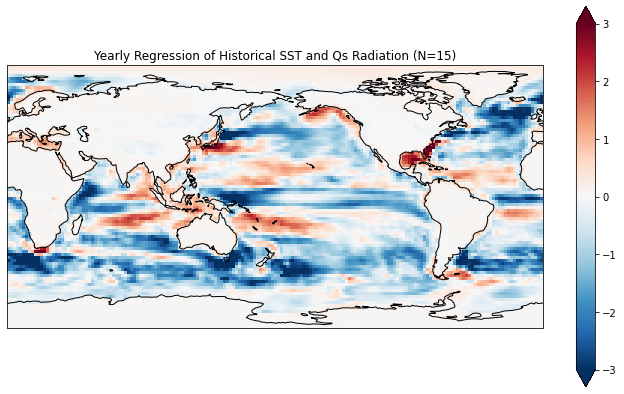

In [10]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surf_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Regression of Historical SST and Qs Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Regression of Historical SST and Qs Radiation (N=15)')

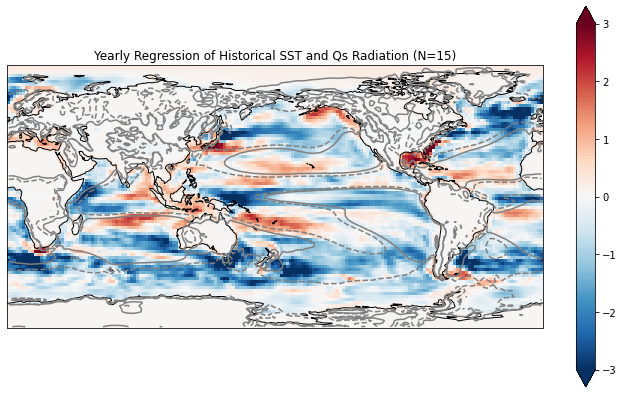

In [11]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surf_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Regression of Historical SST and Qs Radiation (N=15)')

# Testing

In [ ]:
sst_toa_fit = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/yearly_regression_sst_toa_hist_15model.nc')

In [7]:
sst_toa_fit_mean = sst_toa_fit.mean('name')

Text(0.5, 1.0, 'Yearly Regression of Historical SST and TOA Radiation (N=15)')

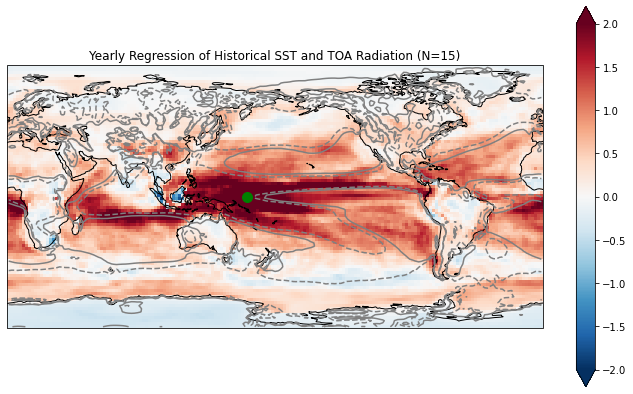

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.plot(160,0, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Regression of Historical SST and TOA Radiation (N=15)')

In [17]:
sst_series = dataarray_SST_hist.sel(lat=0,method='nearest').sel(lon=160,method='nearest').mean('name')
toa_series = dataarray_TOA_hist.sel(lat=0,method='nearest').sel(lon=160,method='nearest').mean('name')

In [18]:
toa_series

<xarray.DataArray (time: 1500)>
array([66.78177943, 82.44297694, 90.41911492, ..., 88.66645831,
       80.17698168, 71.1197405 ])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
    lat      int64 1
    lon      int64 161

Text(0.5, 1.0, 'Yearly Regression - SST, TOA Hist. (N=15)')

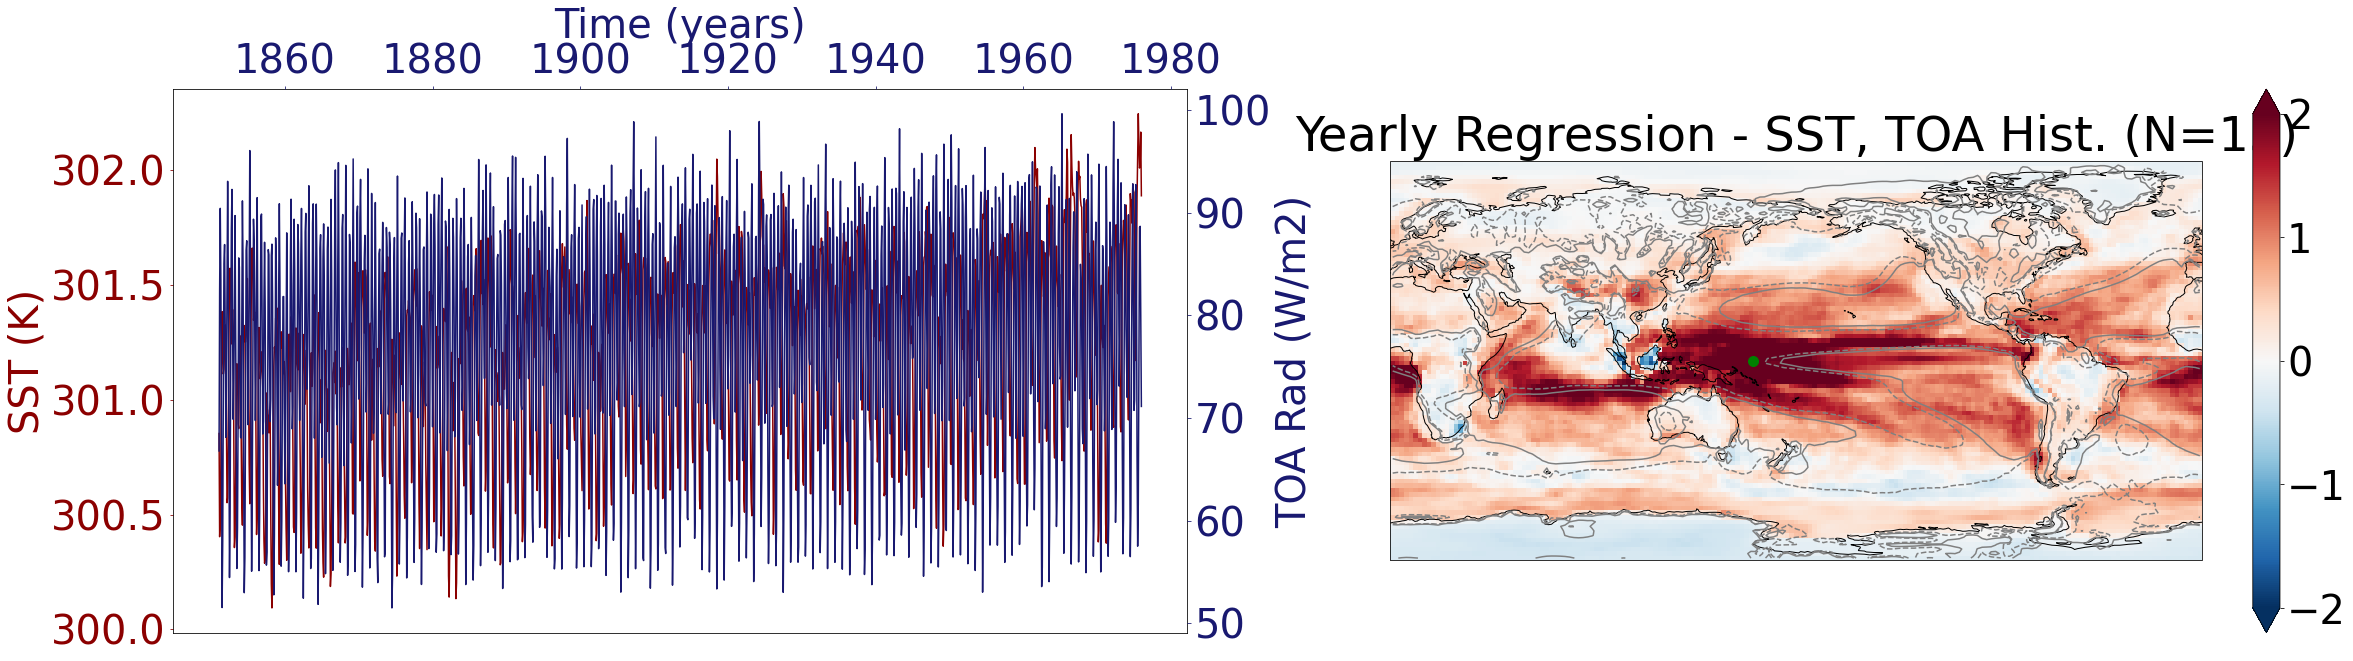

In [24]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)
#top=300
#bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)
lat = 0
lon = 160

ax = fig.add_subplot(121, label="SST")
ax2 = fig.add_subplot(121, label="TOA Rad", frame_on=False)
ax.xaxis.set_visible(False)
ax.plot(sst_series['time'].values, sst_series, color="darkred")
ax.set_xlabel('Time (years)', color="darkred")
ax.set_ylabel('SST (K)', color="darkred")
#ax.set_ylim(bottom=76,top=78)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(toa_series['time'].values,toa_series, color="midnightblue")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time (years)', color="midnightblue") 
ax2.set_ylabel('TOA Rad (W/m2)', color="midnightblue")  
#ax2.set_ylim(top=80,bottom=78)
ax2.xaxis.set_label_position('top') 
#ax2.yaxis.set_visible(False)
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="midnightblue")
ax2.tick_params(axis='y', colors="midnightblue")

ax3 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_mean.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
ax3.coastlines(color='black', linewidth=1)
plt.plot(160,0, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
vert_ds.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.set_title('Yearly Regression - SST, TOA Hist. (N=15)')

In [25]:
sst_rolling = dataarray_SST_hist.rolling(time=12, center=True).mean('time')
sst_series = sst_rolling.mean('name').sel(lat=0,method='nearest').sel(lon=160,method='nearest')
toa_rolling = dataarray_TOA_hist.rolling(time=12, center=True).mean('time')
toa_series = toa_rolling.mean('name').sel(lat=0,method='nearest').sel(lon=160,method='nearest')

Text(0.5, 1.0, 'Yearly Regression - SST, TOA Hist. (N=15)')

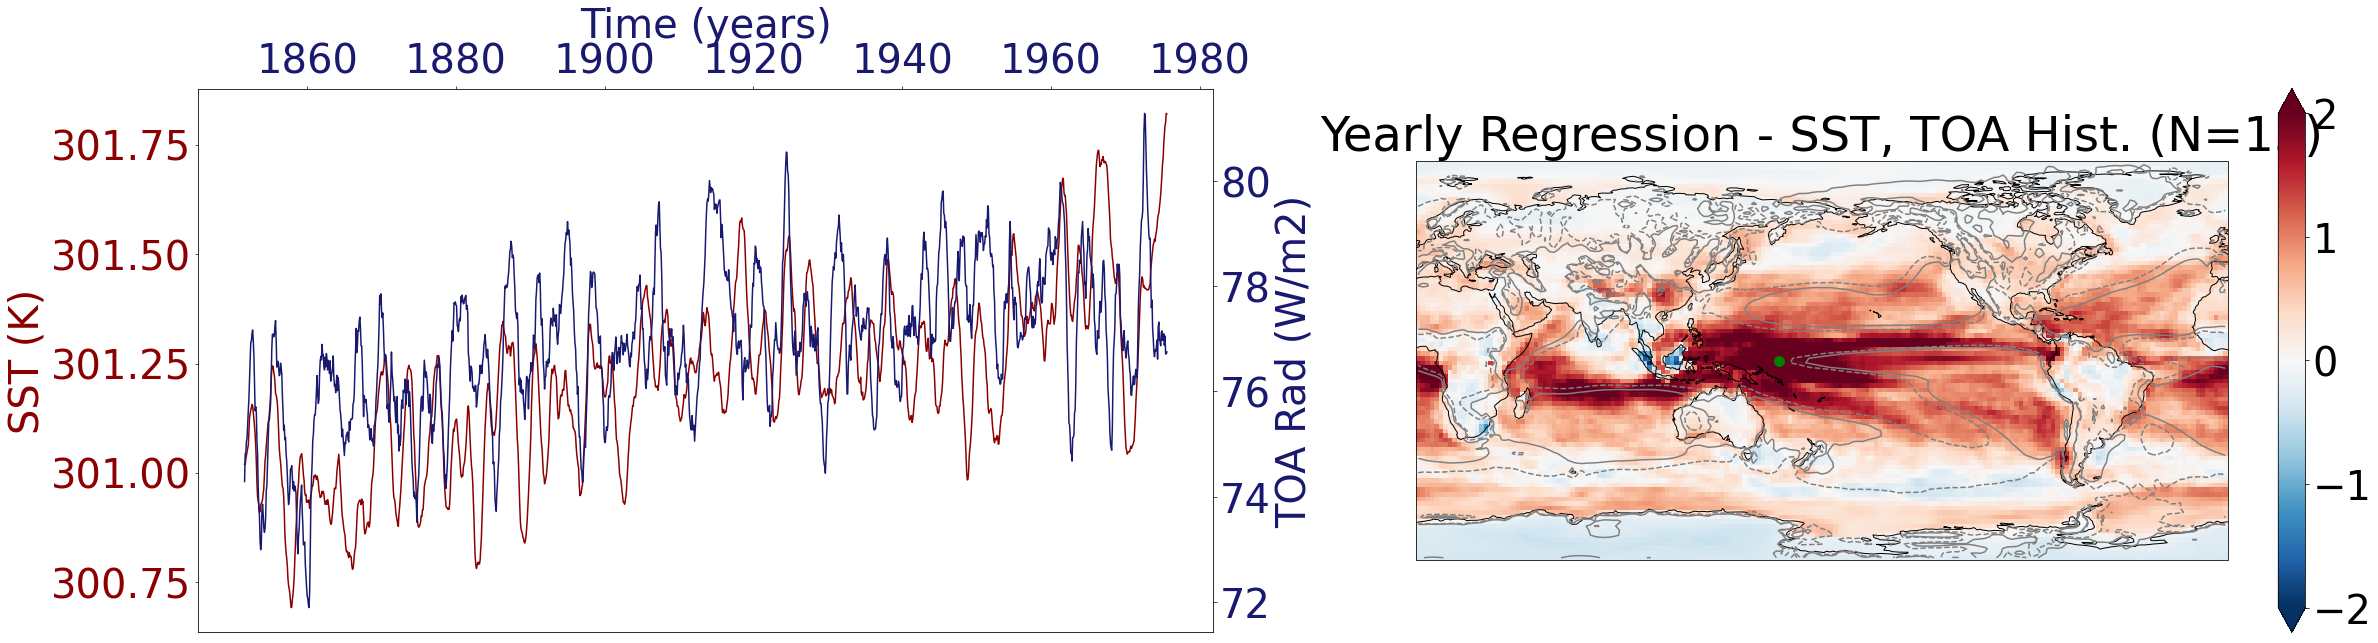

In [26]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)
#top=300
#bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)
lat = 0
lon = 160

ax = fig.add_subplot(121, label="SST")
ax2 = fig.add_subplot(121, label="TOA Rad", frame_on=False)
ax.xaxis.set_visible(False)
ax.plot(sst_series['time'].values, sst_series, color="darkred")
ax.set_xlabel('Time (years)', color="darkred")
ax.set_ylabel('SST (K)', color="darkred")
#ax.set_ylim(bottom=76,top=78)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(toa_series['time'].values,toa_series, color="midnightblue")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time (years)', color="midnightblue") 
ax2.set_ylabel('TOA Rad (W/m2)', color="midnightblue")  
#ax2.set_ylim(top=80,bottom=78)
ax2.xaxis.set_label_position('top') 
#ax2.yaxis.set_visible(False)
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="midnightblue")
ax2.tick_params(axis='y', colors="midnightblue")

ax3 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_mean.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
ax3.coastlines(color='black', linewidth=1)
plt.plot(160,0, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
vert_ds.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.set_title('Yearly Regression - SST, TOA Hist. (N=15)')